# Optimizing QAOA

Consider a quantum alternating operator ansatz(QAOA) consisting of two types of driving Hamiltonian. We consider the following form of control sequence:
$$
U(\{\alpha_i, \beta_i| i=1,\ldots n \}) = e^{i\beta_n h^{(2)}} e^{i\alpha_n h^{(1)}}\cdots e^{i\beta_1 h^{(2)}}e^{i\alpha_1 h^{(1)}}.
$$
Suppose we change only one of the parameters. We are interested in the smoothnes of the energy landscape. Suppose that the energy landscape can be approximated well by a few Fourier coefficients. That is, there exists a rank-$r$ approximation of the function.
$$
\inf_{\{a_i \}} |E(\alpha_i) - \sum_{i=1} a_{j_i} \cos \alpha_i| \leq \epsilon.
$$
Let the approximation be $\tilde{E}(\alpha_i)$. Then the global minimum of the approximation is by definition at most $\epsilon$ apart from the global minimum of the original function. 

## Comparison 

There are two quantities to consider. The first is the sample complexity: how many samples do we need to find the global minimum up to an error $\epsilon$? The second is the total computation time. What is the actual amount of time to compute the global minimum?

In this note, we compare three different methods, under two assumptions.

### Assumptions

In order to compare different optimization methods, we will need to make a few nontrivial assumptions.

#### Periodicity
1. Periodic case: In certain cases, we are promised that $E(\alpha_i)= E(\alpha_i + \pi)$. In this case, we are only interested in $\alpha_i \in [0,\pi]$.

2. Aperiodic case: The periodicity assumption will be invalid in general. In this case, we will need to introduce a cutoff for the maximum value of $\alpha_i$. In the experiment, it will make sense to use $\alpha_i \in [0, 1/\tau_d]$, where $\tau_d$ is the coherence time.

#### Continuity
We will assume that there is a finite Lipschitz constant L:
$$
|E(x) - E(y)| \leq L|x-y|.
$$

#### Convexity
Of course $E(\alpha_i)$ will not be convex in general, but we can still assume that it is and then compare different methods, at least for comparing gradient-based methods.

#### Sparse Fourier coefficients
Let us assume that $E(\alpha_i)$ has only $k$ Fourier coefficients.

### Methods
1. Brute-force search: Divide up the interval

2. Gradient descent: Estimate the gradient at a given point, and then perform gradient descent. Note that there will be a stochastic noise.

3. Fitting-based method: Measure energy for a few values of $\alpha_i$ and fit to a function with sparse Fourier coefficient.

### Sample Complexity

Gradient descent algorithm, applied to a convex and differentiable function with a finite Lipschitz constant, converges in time $1/\epsilon$.

1. If we apply the gradient descent algorithm, we probably need to estimate the gradient with a statistical noise of at least $\epsilon$. So the total sample complexity would scale as $O(\frac{1}{\epsilon^3})$. Actually, because one must use $O(1/\epsilon)$ iterations, a sum of noise over these steps may fluctuate with a prefactor $O(\sqrt{1/\epsilon})$. In order to suppress this contribution up to a $O(\epsilon)$ error, the statistical accuracy for estimating gradient must be $O(\epsilon^{3/2})$. In that case, the total sample complexity would scale as $O(\frac{1}{\epsilon^4})$.


2. Suppose we have a promise that there is a rank-$r$ approximation. Then we have a sample complexity of probably $O(\frac{r}{\epsilon^2})$.

### Time Estimate

1. If we estimate the gradient directly, we have $T_{\text{total}} = O(\frac{\tau_q}{\epsilon^3})$, where $\tau_q$ is the time for one-shot measurement. But according to a more conservative analysis given above, the total might scale as $T_{\text{total}} = O(\frac{\tau_q}{\epsilon^4})$.

2. If we fit the function, then we have $T_{\text{total}} = O(\frac{\tau_q r}{\epsilon^2}) + O(\frac{r\tau_c}{\epsilon})$, where $\tau_c$ is the time for elementary arithmetic operations involving trigonometric functions. Assuming that $\tau_c \leq \tau_q$, the second term becomes negligible. So we see that there is an advantage in fitting the function to some fixed form. 


In [17]:
import numpy as np
import scipy.linalg as la
from scipy import sparse
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
import cvxpy as cvx
import sklearn.linear_model as lm

# Experiment

As a test example, suppose we are trying to optimize the following objective function.
$$
E(\theta) = \langle \psi| (e^{-i\theta Z})^{\otimes k}O(e^{i\theta Z})^{\otimes k}|\psi \rangle
$$
for a random observable $O$ and a arandom state $| \psi\rangle$. Here $|\psi\rangle$ is chosen randomly uniformly over the Hilbert space and $O= U(Z\otimes I \otimes \cdots \otimes I)U^{\dagger}$.

In [26]:
# Number of qubits
n= 8
# Define Z
Z= np.array([[1,0],[0,-1]])

In [27]:
# Random Unitary 1
X = (np.random.randn(2**n, 2**n) + 1j * np.random.randn(2**n, 2**n))/np.sqrt(2)
Q,R = np.linalg.qr(X)
R = np.diag(np.diag(R)/abs(np.diag(R)))
U1 = Q @ R

# Random Unitary 2
X = (np.random.randn(2**n, 2**n) + 1j * np.random.randn(2**n, 2**n))/np.sqrt(2)
Q,R = np.linalg.qr(X)
R = np.diag(np.diag(R)/abs(np.diag(R)))
U2 = Q @ R

In [28]:
itt = 50


# Create an observable
I = np.array([[1,0],[0,1]])
ob = Z
for k in range(n-1):
    ob = sparse.kron(ob, I)
    
    
# Initialize the record
Record = []

for i in range(itt):
    # Create a state
    psi = np.zeros(2**n)
    psi[0] = 1
    psi = U1 @ psi
    # Create a single unitary
    theta = np.pi * i / itt
    ctrl_loc = la.expm(1j * theta * Z)
    
    # Create a control unitary
    ctrl = 1
    for j in range(n):
        ctrl = sparse.kron(ctrl, ctrl_loc)
        
    # Apply the control
    psi = ctrl @ psi
    
    # Measure
    answer = np.real(psi.conj().T @ U2 @ ob @ U2.conj().T @ psi)
    Record.append(answer)
    

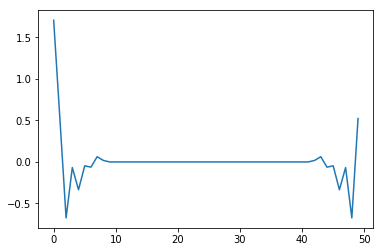

array([ 1.70590933e+00,  5.22188871e-01, -6.74150988e-01, -6.75879307e-02,
       -3.34741499e-01, -4.67299101e-02, -6.27973269e-02,  6.24818530e-02,
        1.78171329e-02,  2.22044605e-16, -2.22044605e-16,  1.97702754e-16,
       -2.08166817e-16, -2.28983499e-16,  2.49800181e-16, -4.89192020e-16,
        2.22044605e-16, -1.17961196e-16,  1.11022302e-16,  8.32667268e-16,
        2.22044605e-16, -1.03832354e-15,  3.47812057e-16, -3.72965547e-16,
        2.53269627e-16,  7.04514572e-16,  2.91433544e-16, -2.63677968e-16,
        1.38777878e-17, -5.75928194e-16,  2.22044605e-16,  8.71790085e-16,
        1.79543880e-16, -4.90926744e-16,  9.36750677e-17, -5.79180801e-16,
        5.13478149e-16, -8.32667268e-17, -2.08166817e-16,  3.40005801e-16,
       -2.22044605e-16, -2.53213906e-16,  1.78171329e-02,  6.24818530e-02,
       -6.27973269e-02, -4.67299101e-02, -3.34741499e-01, -6.75879307e-02,
       -6.74150988e-01,  5.22188871e-01])

In [29]:
myfft=np.real(np.fft.fft(Record))
plt.plot(myfft)
plt.show()
myfft

One can see that the number of Fourier coefficient is small, but this was to some extent expected. The number of $e^{i\theta Z}$ term is at most $16$, so the sparsity may be coming from the fact that $16$ is a small number. In order to test how sparse the Fourier coefficients are, we can imagine identifying some of the $\alpha_i$s to be equal to each other. 

In [30]:
itt = 100
layers = 5

# Create an observable
I = np.array([[1,0],[0,1]])
ob = Z
for k in range(n-1):
    ob = sparse.kron(ob, I)
    
    
# Initialize the record
Record = []

for i in range(itt):
    # Create a state
    psi = np.zeros(2**n)
    psi[0] = 1
    psi = U1 @ psi
    # Create a single unitary
    theta = np.pi * i / itt
    ctrl_loc = la.expm(1j * theta * Z)
    
    # Create a control unitary
    ctrl = 1
    for j in range(n):
        ctrl = sparse.kron(ctrl, ctrl_loc)
        
    # Create an ansatz
    psi_ansatz = psi
    for j in range(layers):
        psi_ansatz = ctrl @ psi_ansatz
        psi_ansatz = U2.conj().T @ psi_ansatz
    
    # Measure
    answer = np.real(psi_ansatz.conj().T @ ob @ psi_ansatz)
    Record.append(answer)

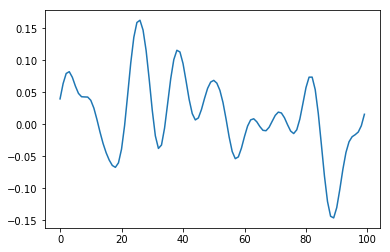

In [31]:
plt.plot(Record)

## Complexified CVX

In [32]:
def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1J / N )
    W = np.power( omega, i * j )
    return W

In [33]:
dft_mat = DFT_matrix(itt)
ift_mat = np.conj(dft_mat)/itt
rec_ft = dft_mat@Record

Complexifying the results, i.e. v -> [Re(v), Im(v)]

In [34]:
comp_ift_mat = np.block([[np.real(ift_mat),-np.imag(ift_mat)],[np.imag(ift_mat),np.real(ift_mat)]])
comp_record = np.block([np.real(Record),np.imag(Record)])
comp_record_ft = np.block([np.real(rec_ft),np.imag(rec_ft)])

In [35]:
def reconstruct_sparse_complex(m_vecs,y_vals,verb=False):
    
    vx = cvx.Variable(2*itt)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [m_vecs*vx == y_vals]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(verbose=verb)
    
    return np.squeeze(np.array(vx.value))[:itt]+1j*np.squeeze(np.array(vx.value))[itt:]

In [36]:
cost_record_complex = []
cost_record_complex_time = []
for m in range(10,itt):
    rand_indx = np.random.choice(np.arange(itt),m,replace=False)
    rand_indx = np.append(rand_indx,itt+rand_indx)
    recon_results = reconstruct_sparse_complex(comp_ift_mat[rand_indx],comp_record[rand_indx])
    cost_record_complex.append(np.linalg.norm(rec_ft-recon_results))
    cost_record_complex_time.append(np.linalg.norm((ift_mat@recon_results)-np.array(Record)))

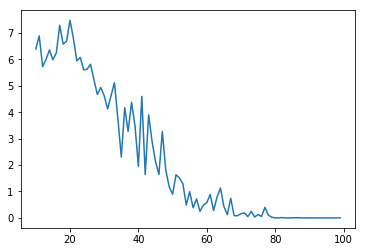

In [37]:
plt.plot(np.arange(10,itt),cost_record_complex)
# plt.yscale('log')

## Cosine transform

In [38]:
idct_matrix = spfft.idct(np.identity(itt), norm='ortho', axis=0)

In [39]:
dct_matrix = spfft.dct(np.identity(itt), norm='ortho', axis=0)

In [40]:
rec_ct = dct_matrix@Record

In [41]:
def reconstruct_sparse_cosine(m_vecs,y_vals,verb=False):
    
    vx = cvx.Variable(itt)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [m_vecs*vx == y_vals]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(verbose=verb)
    
    return np.squeeze(np.array(vx.value))

In [46]:
cost_record_cos = []
cost_record_cos_time = []
for m in range(10,itt):
    rand_indx = np.random.choice(np.arange(itt),m,replace=False)
    recon_results = reconstruct_sparse_cosine(idct_matrix[rand_indx],np.array(Record)[rand_indx])
    cost_record_cos.append(np.linalg.norm(rec_ct-recon_results))
    cost_record_cos_time.append(np.linalg.norm(idct_matrix@recon_results-np.array(Record)))

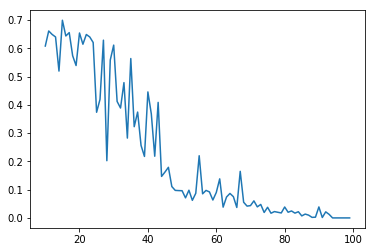

In [48]:
plt.plot(np.arange(10,itt),cost_record_cos)

# plt.yscale('log')

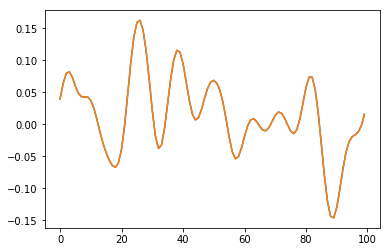

In [49]:
plt.plot(idct_matrix@recon_results)
plt.plot(Record)

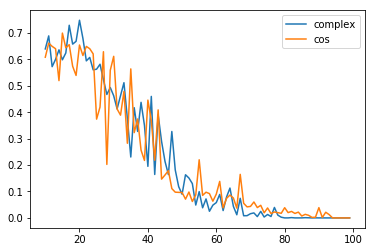

In [50]:
plt.plot(np.arange(10,itt),cost_record_complex_time,label='complex')
plt.plot(np.arange(10,itt),cost_record_cos_time,label='cos')
plt.legend()

## LASSO

In [85]:
cost_record_lasso = []
cost_record_lasso_time = []
for m in range(10,itt):
    rand_indx = np.random.choice(np.arange(itt),m,replace=False)
    clf = lm.Lasso(alpha=0.00001, max_iter=10000, tol=0.0001,fit_intercept=False)
#     clf = lm.LassoLars(alpha=0.001,fit_intercept=False)
    clf.fit(idct_matrix[rand_indx],np.array(Record)[rand_indx])
    cost_record_lasso.append(np.linalg.norm(rec_ct-clf.coef_))
    cost_record_lasso_time.append(np.linalg.norm(idct_matrix@clf.coef_-np.array(Record)))

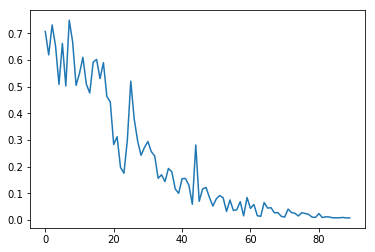

In [86]:
# plt.plot(cost_record_lasso)
plt.plot(cost_record_lasso_time)

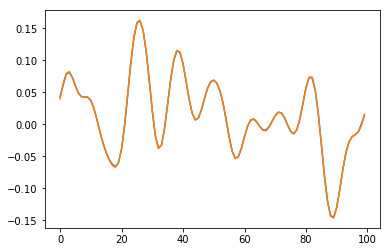

In [87]:
plt.plot(idct_matrix@clf.coef_)
plt.plot(Record)

## IHT

In [190]:
itemp = 0
jtemp = 0
while jtemp<5 and itemp <10:
    itemp+=1
    jtemp+=1

In [192]:
def iterative_ht(m_vecs,y_vals,sparsity,tol = 1e-3, max_iter=200,verbose=True):
    
    x_vec = np.zeros(m_vecs.shape[1])
    ic = 0
    while np.linalg.norm(y_vals-m_vecs@x_vec)>tol and ic<max_iter:
        ic += 1
        x_vec = x_vec + m_vecs.T@(y_vals-m_vecs@x_vec)
        x_vec[np.argsort(-np.abs(x_vec))[sparsity:]] = 0
        
        if verbose:
            workdone = (i+1)/max_iter
            print("\rProgress: [{0:50s}] {1:.1f}%".format('#' * int(workdone * 50), workdone*100), end="", flush=True)
    return x_vec 

In [196]:
cost_record_iht = []
cost_record_iht_time = []
for m in range(10,itt):
    rand_indx = np.random.choice(np.arange(itt),m,replace=False)
    x_sol = iterative_ht(idct_matrix[rand_indx],np.array(Record)[rand_indx],sparsity = 25,verbose=False)
    cost_record_iht.append(np.linalg.norm(rec_ct-x_sol))
    cost_record_iht_time.append(np.linalg.norm(idct_matrix@x_sol-np.array(Record)))

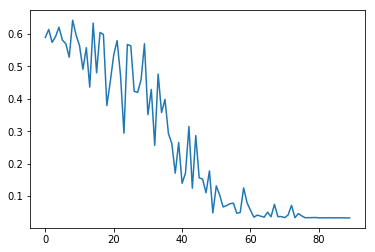

In [197]:
plt.plot(cost_record_iht)

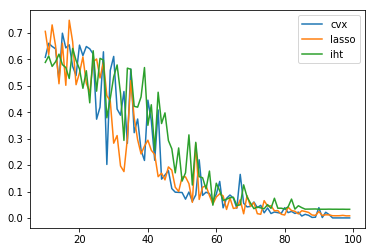

In [198]:
plt.plot(np.arange(10,itt),cost_record_cos_time,label='cvx')
plt.plot(np.arange(10,itt),cost_record_lasso_time,label='lasso')
plt.plot(np.arange(10,itt),cost_record_iht_time,label='iht')
plt.legend()